In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans,  DBSCAN
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from sklearn import metrics
from sklearn.manifold import TSNE
import datetime

In [2]:
# 忽略报错
import warnings
warnings.filterwarnings("ignore")

# 中文
plt.rcParams['font.family'] = ['Arial Unicode MS'] 

In [3]:
# 导入数据
mobike = pd.read_csv('week4.mobike.csv', index_col=0)

In [4]:
mobike.head()

,user_id,start_time,end_time,timeduration,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
439283,21499218,11/14/2018 7:37,11/14/2018 7:44,7,2631,436,319,Greenview Ave & Diversey Pkwy,67,Sheffield Ave & Fullerton Ave,Subscriber,Male,1982.0,37
603317,21694389,12/18/2018 19:02,12/18/2018 19:10,7,1565,445,164,Franklin St & Lake St,195,Columbus Dr & Randolph St,Subscriber,Male,1988.0,31
109957,21110722,10/9/2018 12:37,10/9/2018 12:55,18,2231,1090,163,Damen Ave & Clybourn Ave,69,Damen Ave & Pierce Ave,Customer,Male,1989.0,30
428082,21485409,11/12/2018 12:30,11/12/2018 12:40,9,4226,581,226,Racine Ave & Belmont Ave,308,Seeley Ave & Roscoe St,Subscriber,Female,1989.0,30
395437,21445994,11/7/2018 7:29,11/7/2018 7:35,6,3475,390,77,Clinton St & Madison St,621,Aberdeen St & Randolph St,Subscriber,Male,1979.0,40


# 1. 数据概况和数据清洗

## 1.1 数据概览

In [5]:
# 基本字段
mobike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6427 entries, 439283 to 278179
Data columns (total 14 columns):
user_id              6427 non-null int64
start_time           6427 non-null object
end_time             6427 non-null object
timeduration         6427 non-null int64
bikeid               6427 non-null int64
tripduration         6427 non-null int64
from_station_id      6427 non-null int64
from_station_name    6427 non-null object
to_station_id        6427 non-null int64
to_station_name      6427 non-null object
usertype             6427 non-null object
gender               5938 non-null object
birthyear            5956 non-null float64
age                  6427 non-null object
dtypes: float64(1), int64(6), object(7)
memory usage: 753.2+ KB


- 总共6427行数据
- 信息有冗余，如[age, birthyear]，[start_time, end_time和timeduration]
- 以下字段没有用，可以删除：user_id, bikeid, from_station_id, to_station_id, from_station_name, to_station_name
- 以下字段类别有问题：start_time和end_time应为datetime类型；age应为int类型；user_id、bikeid、from_station_id、to_station_id应为str类型
- timeduration应该是以分为单位，tripduration是以米为单位

## 1.2 类别修正

In [6]:
# 类别处理
mobike['start_time'] = pd.to_datetime(mobike['start_time'])
mobike['end_time'] = pd.to_datetime(mobike['end_time'])

mobike['user_id'] = mobike['user_id'].astype('str')
mobike['bikeid'] = mobike['bikeid'].astype('str')
mobike['from_station_id'] = mobike['from_station_id'].astype('str')
mobike['to_station_id'] = mobike['to_station_id'].astype('str')

In [7]:
mobike.age.value_counts()

       471
30     352
27     341
29     320
28     305
32     286
26     283
31     275
33     242
34     233
35     228
25     227
36     197
37     164
24     159
39     145
38     132
40     128
41     110
23     106
42     100
50      94
45      94
43      86
47      82
44      81
56      78
49      78
55      77
51      71
      ... 
48      61
58      59
53      59
46      58
20      50
52      49
61      39
60      36
63      35
21      35
62      34
22      33
65      20
64      20
67      19
19      18
68      17
66      12
69      11
18       7
70       5
73       4
71       3
101      2
17       2
74       2
72       1
79       1
77       1
113      1
Name: age, Length: 63, dtype: int64

In [8]:
mobike[mobike['age']==' ']['birthyear'].isnull().all()

True

In [9]:
(mobike[mobike['birthyear'].isnull()]['age']==' ').all()

True

- 发现age一列是由birthyear计算得来，且age字段里空白值' '数量对应birthyear里面的缺失值，因此age重新计算

In [10]:
# age处理
mobike['age'] = datetime.datetime.today().year - mobike['birthyear']

In [11]:
mobike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6427 entries, 439283 to 278179
Data columns (total 14 columns):
user_id              6427 non-null object
start_time           6427 non-null datetime64[ns]
end_time             6427 non-null datetime64[ns]
timeduration         6427 non-null int64
bikeid               6427 non-null object
tripduration         6427 non-null int64
from_station_id      6427 non-null object
from_station_name    6427 non-null object
to_station_id        6427 non-null object
to_station_name      6427 non-null object
usertype             6427 non-null object
gender               5938 non-null object
birthyear            5956 non-null float64
age                  5956 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(2), object(8)
memory usage: 753.2+ KB


## 1.3 缺失值分析

In [12]:
# 缺失值
mobike.isnull().sum().reset_index().rename(columns={'index':'字段', 0:'缺失值数量'})

,字段,缺失值数量
0,user_id,0
1,start_time,0
2,end_time,0
3,timeduration,0
4,bikeid,0
5,tripduration,0
6,from_station_id,0
7,from_station_name,0
8,to_station_id,0
9,to_station_name,0


- gender，birthyear，age存在缺失值，需要处理

## 1.4 重复值分析

In [13]:
# 重复值
print("重复行数量：%d" % sum(mobike.duplicated()))

重复行数量：0


## 1.5 离群值和异常值分析

In [14]:
# 数值型变量离群值
mobike.describe()

,timeduration,tripduration,birthyear,age
count,6427.000000,6.427000e+03,5956.000000,5956.000000
mean,11.778902,1.060471e+03,1982.488583,37.511417
std,9.692236,1.456811e+04,11.147859,11.147859
min,0.000000,6.100000e+01,1906.000000,18.000000
25%,5.000000,3.490000e+02,1977.000000,29.000000
50%,9.000000,5.590000e+02,1986.000000,34.000000
75%,15.000000,9.320000e+02,1991.000000,43.000000
max,59.000000,1.139070e+06,2002.000000,114.000000


- timeduration里最小值和最大值为0分钟和59分钟，其中0分钟不太正常，需要查看
- tripduration的极值差距也很大，最小为61米，最大为1140000米
- 年龄最大值为114岁
- 以上三个数值型字段均存在离群值需要处理

In [15]:
mobike[mobike['timeduration']<1]

,user_id,start_time,end_time,timeduration,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
109113,21109759,2018-10-09 11:29:00,2018-10-09 12:29:00,0,4875,3616,225,Halsted St & Dickens Ave,172,Rush St & Cedar St,Customer,NaN,NaN,NaN
72232,21067313,2018-10-06 10:15:00,2018-10-06 11:15:00,0,4733,3606,419,Lake Park Ave & 53rd St,76,Lake Shore Dr & Monroe St,Customer,NaN,NaN,NaN
69595,21064115,2018-10-05 18:27:00,2018-10-05 19:28:00,0,2064,3650,50,Clark St & Congress Pkwy,283,LaSalle St & Jackson Blvd,Customer,Male,1989.0,31.0
302629,21336986,2018-10-27 15:33:00,2018-10-27 16:34:00,0,5051,3634,3,Shedd Aquarium,199,Wabash Ave & Grand Ave,Customer,NaN,NaN,NaN
592619,21681993,2018-12-17 09:17:00,2018-12-17 10:18:00,0,4316,3652,99,Lake Shore Dr & Ohio St,96,Desplaines St & Randolph St,Subscriber,Male,1988.0,32.0


- 需要替换0为60

In [16]:
mobike['timeduration'] = mobike['timeduration'].replace(0, 60)

In [17]:
mobike.describe()

,timeduration,tripduration,birthyear,age
count,6427.000000,6.427000e+03,5956.000000,5956.000000
mean,11.825580,1.060471e+03,1982.488583,37.511417
std,9.779498,1.456811e+04,11.147859,11.147859
min,1.000000,6.100000e+01,1906.000000,18.000000
25%,5.000000,3.490000e+02,1977.000000,29.000000
50%,9.000000,5.590000e+02,1986.000000,34.000000
75%,15.000000,9.320000e+02,1991.000000,43.000000
max,60.000000,1.139070e+06,2002.000000,114.000000


In [18]:
# 类别型变量异常值
mobike.gender.unique()

array(['Male', 'Female', nan], dtype=object)

- 需要填充nan为Unknown

In [19]:
mobike.usertype.unique()

array(['Subscriber', 'Customer'], dtype=object)

## 1.6 衍生变量探索

In [20]:
# 拓展探索datetime类型变量start_time和end_time，增加features
mobike['start_time'].dt.year.unique()

array([2018])

In [21]:
mobike['start_time'].dt.month.unique()

array([11, 12, 10])

- 只有2018年10月-12月的数据，提取月份、年份没有意义，因此提取工作日和小时的信息，最后可以进行分箱操作

In [22]:
mobike['start_weekday'] = mobike['start_time'].dt.weekday
mobike['start_hour'] = mobike['start_time'].dt.hour

In [23]:
mobike.head()

,user_id,start_time,end_time,timeduration,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age,start_weekday,start_hour
439283,21499218,2018-11-14 07:37:00,2018-11-14 07:44:00,7,2631,436,319,Greenview Ave & Diversey Pkwy,67,Sheffield Ave & Fullerton Ave,Subscriber,Male,1982.0,38.0,2,7
603317,21694389,2018-12-18 19:02:00,2018-12-18 19:10:00,7,1565,445,164,Franklin St & Lake St,195,Columbus Dr & Randolph St,Subscriber,Male,1988.0,32.0,1,19
109957,21110722,2018-10-09 12:37:00,2018-10-09 12:55:00,18,2231,1090,163,Damen Ave & Clybourn Ave,69,Damen Ave & Pierce Ave,Customer,Male,1989.0,31.0,1,12
428082,21485409,2018-11-12 12:30:00,2018-11-12 12:40:00,9,4226,581,226,Racine Ave & Belmont Ave,308,Seeley Ave & Roscoe St,Subscriber,Female,1989.0,31.0,0,12
395437,21445994,2018-11-07 07:29:00,2018-11-07 07:35:00,6,3475,390,77,Clinton St & Madison St,621,Aberdeen St & Randolph St,Subscriber,Male,1979.0,41.0,2,7


## 1.7 数据清洗

In [24]:
# 去掉信息冗余和不必要的变量
mobike_clean = mobike.copy()
# 去掉无用处变量
mobike_clean.drop(['user_id', 'bikeid', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'birthyear'], axis=1, inplace=True)
# 去掉start_time和end_time，保留timeduration和衍生变量
mobike_clean.drop(mobike.select_dtypes('datetime64'), axis=1, inplace=True)

In [25]:
# 填充gender缺失值
mobike_clean['gender'] = mobike_clean['gender'].fillna('Unknown')

In [26]:
mobike_clean.head()

,timeduration,tripduration,usertype,gender,age,start_weekday,start_hour
439283,7,436,Subscriber,Male,38.0,2,7
603317,7,445,Subscriber,Male,32.0,1,19
109957,18,1090,Customer,Male,31.0,1,12
428082,9,581,Subscriber,Female,31.0,0,12
395437,6,390,Subscriber,Male,41.0,2,7


- 还剩离群值未处理，以及age的缺失值

# 2. 单变量分析

## 2.1 类别型变量

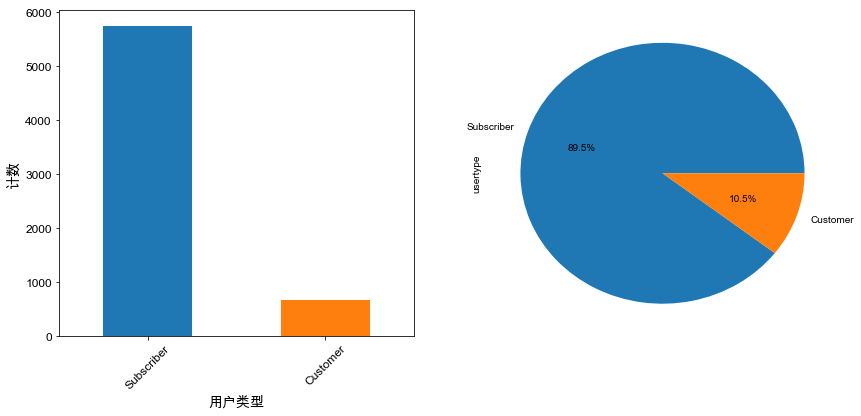

In [27]:
# usertype
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
mobike_clean.usertype.value_counts().plot(kind='bar')
plt.tick_params(labelsize=12)
plt.xlabel('用户类型', size=14)
plt.ylabel('计数', size=14)
plt.xticks(rotation = 45);

plt.subplot(1,2,2)
mobike_clean.usertype.value_counts().plot(kind='pie', autopct= '%3.1f%%');

- subscriber占多数

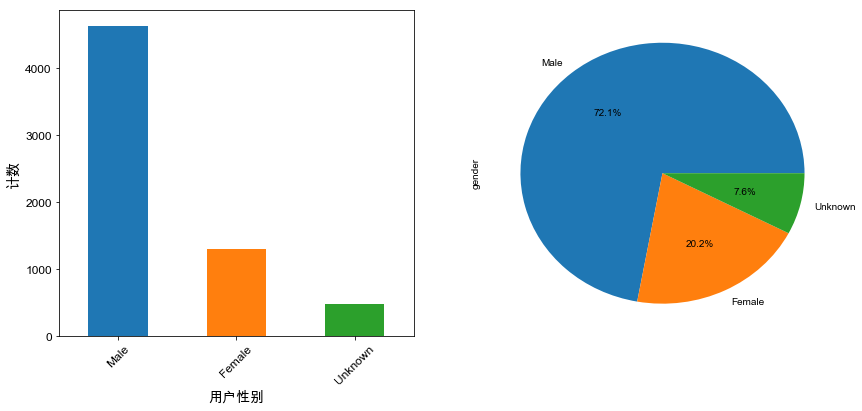

In [28]:
# gender
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
mobike_clean.gender.value_counts().plot(kind='bar')
plt.tick_params(labelsize=12)
plt.xlabel('用户性别', size=14)
plt.ylabel('计数', size=14)
plt.xticks(rotation = 45);

plt.subplot(1,2,2)
mobike_clean.gender.value_counts().plot(kind='pie', autopct= '%3.1f%%');

- 男性用户占多数

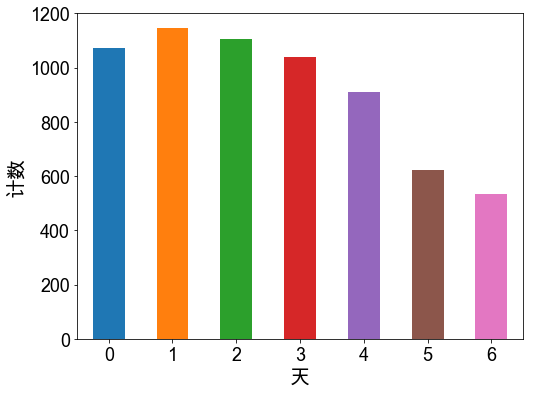

In [29]:
# start_weekday
plt.figure(figsize=(8,6))
mobike_clean.start_weekday.value_counts().sort_index().plot(kind='bar')
plt.tick_params(labelsize=18)
plt.xticks(rotation=0)
plt.xlabel('天', size=20)
plt.ylabel('计数', size=20);

- 工作日使用人次高
- 可考虑分箱为工作日和周末

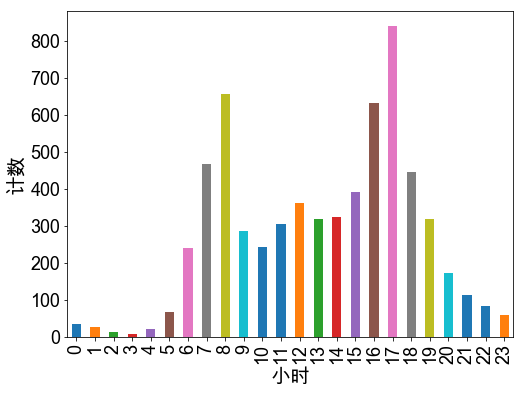

In [30]:
# start_hour
plt.figure(figsize=(8,6))
mobike_clean.start_hour.value_counts().sort_index().plot(kind='bar')
plt.tick_params(labelsize=18)
plt.xlabel('小时', size=20)
plt.ylabel('计数', size=20)
plt.xticks(rotation = 90);

- 高峰时段集中在6-9早高峰和16-18晚高峰，且白天比凌晨和夜晚使用频次高
- 可以考虑分箱为0-6，6-12，12-18，18-24四段

## 2.2 数值型变量

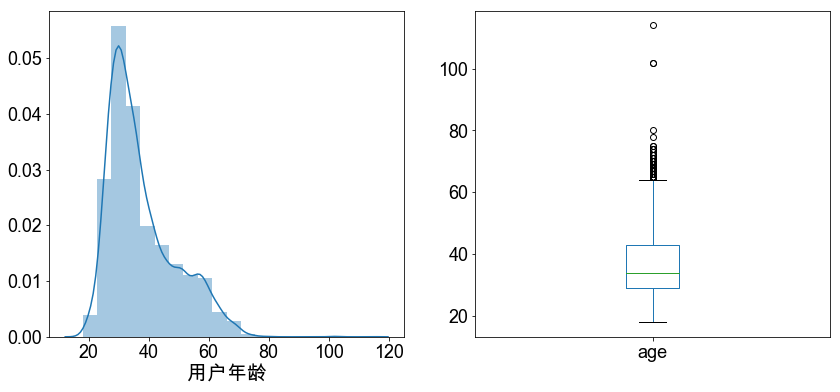

In [32]:
# age
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.distplot(mobike_clean['age'].dropna(how='any'), bins=20)
plt.tick_params(labelsize=18)
plt.xlabel('用户年龄', size=20);

plt.subplot(1,2,2)
mobike_clean['age'].plot(kind='box')
plt.tick_params(labelsize=18)
plt.ylabel('', size=20);

- 分布集中在20-60岁
- 缺失值填充为中位数
- 离群值处理

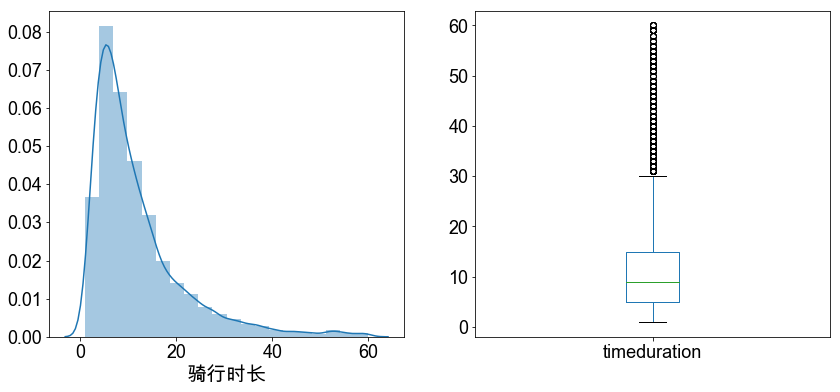

In [33]:
# timeduration
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.distplot(mobike_clean['timeduration'], bins=20)
plt.tick_params(labelsize=18)
plt.xlabel('骑行时长', size=20);

plt.subplot(1,2,2)
mobike_clean['timeduration'].plot(kind='box')
plt.tick_params(labelsize=18);

- 集中分布在20分钟以下
- 离群值处理

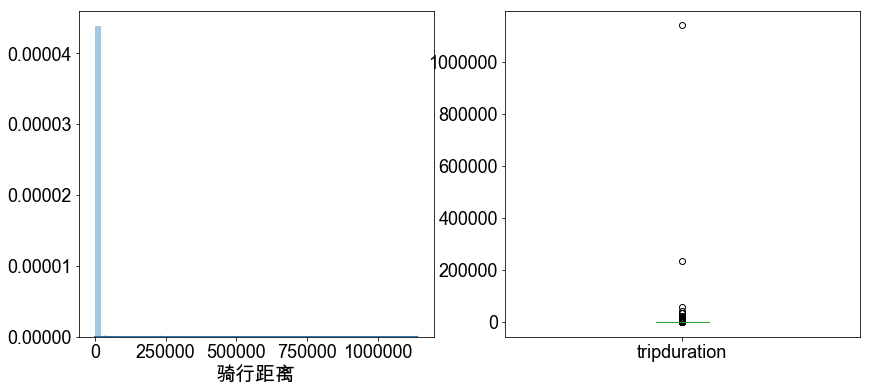

In [34]:
# tripduration
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.distplot(mobike_clean['tripduration'], bins=50)
plt.tick_params(labelsize=18)
plt.xlabel('骑行距离', size=20);

plt.subplot(1,2,2)
mobike_clean['tripduration'].plot(kind='box')
plt.tick_params(labelsize=18);

- 离群值处理

# 3. 数据处理

## 3.1 缺失值处理

In [35]:
# age缺失值处理, 填充为中位数
mobike_clean['age'] = mobike_clean['age'].fillna(np.nanmedian(mobike_clean['age']))
mobike_clean['age'] = mobike_clean['age'].astype('int')

In [36]:
mobike_clean.isnull().sum()

timeduration     0
tripduration     0
usertype         0
gender           0
age              0
start_weekday    0
start_hour       0
dtype: int64

## 3.2 离群值处理

In [37]:
# 定义函数，返回1.5*（75%-25%）+25%作为阈值
def get_threshold(series):
    value_25 = series.describe()['25%']
    value_75 = series.describe()['75%']
    threshold = (value_75-value_25)*1.5 + value_75
    return threshold

In [38]:
# age处理
print("删除了%d行" % (mobike_clean.shape[0]-mobike_clean.drop(mobike_clean[mobike_clean['age']>get_threshold(mobike_clean['age'])].index).shape[0]))
mobike_clean.drop(mobike_clean[mobike_clean['age']>get_threshold(mobike_clean['age'])].index, inplace=True)

删除了263行


In [39]:
# tripduration
print("删除了%d行" % (mobike_clean.shape[0]-mobike_clean.drop(mobike_clean[mobike_clean['tripduration']>get_threshold(mobike_clean['tripduration'])].index).shape[0]))
mobike_clean.drop(mobike_clean[mobike_clean['tripduration']>get_threshold(mobike_clean['tripduration'])].index, inplace=True)

删除了441行


In [40]:
# timeduration
print("删除了%d行" % (mobike_clean.shape[0]-mobike_clean.drop(mobike_clean[mobike_clean['timeduration']>get_threshold(mobike_clean['timeduration'])].index).shape[0]))
mobike_clean.drop(mobike_clean[mobike_clean['timeduration']>get_threshold(mobike_clean['timeduration'])].index, inplace=True)

删除了174行


In [41]:
print("保留了%d行数据，删除了%d数据，占比%.2f" % (mobike_clean.shape[0], mobike.shape[0]-mobike_clean.shape[0], (mobike.shape[0]-mobike_clean.shape[0])/mobike.shape[0]))

保留了5549行数据，删除了878数据，占比0.14


In [42]:
# 类别型变量变成哑变量并去除冗余，且保留原始的分类变量，用于后面可视化
mobike_clean = pd.concat([mobike_clean, pd.get_dummies(mobike_clean[['usertype', 'gender']], drop_first=True)], axis=1)

In [43]:
mobike_clean.head()

,timeduration,tripduration,usertype,gender,age,start_weekday,start_hour,usertype_Subscriber,gender_Male,gender_Unknown
439283,7,436,Subscriber,Male,38,2,7,1,1,0
603317,7,445,Subscriber,Male,32,1,19,1,1,0
109957,18,1090,Customer,Male,31,1,12,0,1,0
428082,9,581,Subscriber,Female,31,0,12,1,0,0
395437,6,390,Subscriber,Male,41,2,7,1,1,0


# 4. 多变量分析

## 4.1 相关性系数

In [44]:
mobike_clean.corr()

,timeduration,tripduration,age,start_weekday,start_hour,usertype_Subscriber,gender_Male,gender_Unknown
timeduration,1.000000,0.998677,0.045227,0.020420,0.036286,-0.233434,-0.136500,0.220889
tripduration,0.998677,1.000000,0.044371,0.021671,0.035925,-0.233549,-0.135674,0.220819
age,0.045227,0.044371,1.000000,-0.047189,-0.075579,0.070333,0.079555,-0.049418
start_weekday,0.020420,0.021671,-0.047189,1.000000,0.008179,-0.111230,-0.041107,0.094443
start_hour,0.036286,0.035925,-0.075579,0.008179,1.000000,-0.039084,-0.039247,0.044535
usertype_Subscriber,-0.233434,-0.233549,0.070333,-0.111230,-0.039084,1.000000,0.302230,-0.781725
gender_Male,-0.136500,-0.135674,0.079555,-0.041107,-0.039247,0.302230,1.000000,-0.387889
gender_Unknown,0.220889,0.220819,-0.049418,0.094443,0.044535,-0.781725,-0.387889,1.000000


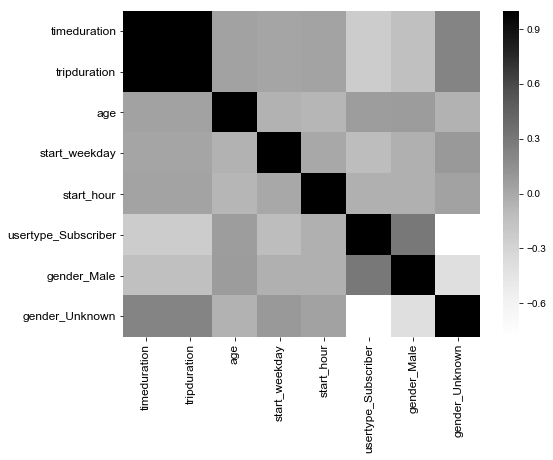

In [45]:
plt.figure(figsize=(8,6))
plt.tick_params(labelsize=12)
h = sns.heatmap(mobike_clean.corr(), cmap = 'Greys')

- 从颜色上看，正相关性比较高的是timeduration和tripduration，gender_Male和usertype_Subscriber，gender_Unknown和timeduration，gender_Unknown和tripduration
- 负相关性比较高的是usertype_Subscriber和gender_Unknown，gender_Male和gender_Unknown

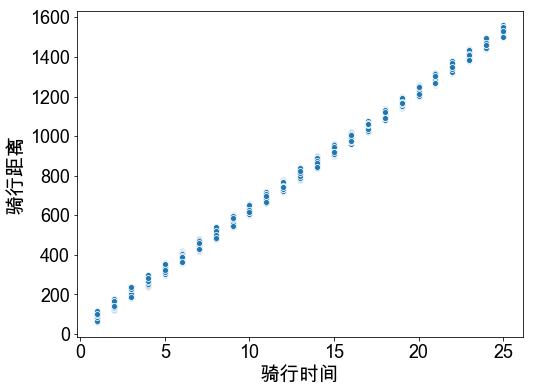

In [111]:
plt.figure(figsize=(8,6))
plt.tick_params(labelsize=18)
sns.scatterplot(x='timeduration', y='tripduration', data=mobike_clean)
plt.xlabel('骑行时间', size=20)
plt.ylabel('骑行距离', size=20);

- 骑行距离和骑行时间呈线性相关，因此只看两者其一即可

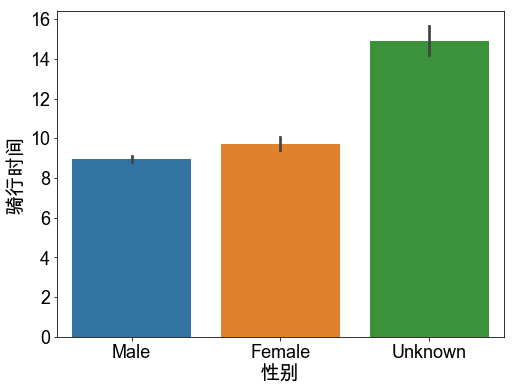

In [115]:
plt.figure(figsize=(8,6))
plt.tick_params(labelsize=18)
sns.barplot(x='gender', y='timeduration', data=mobike_clean)
plt.xlabel('性别', size=20)
plt.ylabel('骑行时间', size=20);

- 未知性别人群的平均骑行时间要比明确性别的用户平均骑行时间长很多
- 女性比男性平均骑行时间要长

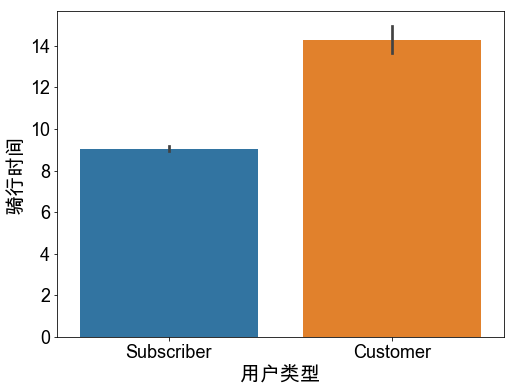

In [116]:
plt.figure(figsize=(8,6))
plt.tick_params(labelsize=18)
sns.barplot(x='usertype', y='timeduration', data=mobike_clean)
plt.xlabel('用户类型', size=20)
plt.ylabel('骑行时间', size=20);

- 付费用户比普通用户平均骑行时间短

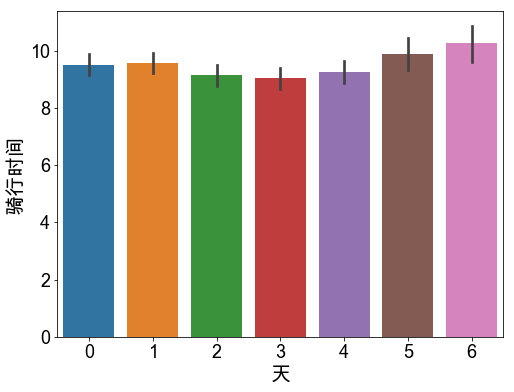

In [118]:
plt.figure(figsize=(8,6))
plt.tick_params(labelsize=18)
sns.barplot(x='start_weekday', y='timeduration', data=mobike_clean)
plt.xlabel('天', size=20)
plt.ylabel('骑行时间', size=20);

- 周末的平均骑行时间比周中长
- 周一、周二相对周三周四周五平均骑行时间略长一点

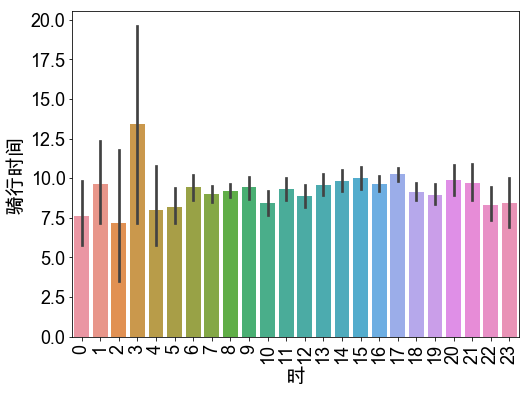

In [120]:
plt.figure(figsize=(8,6))
plt.tick_params(labelsize=18)
sns.barplot(x='start_hour', y='timeduration', data=mobike_clean)
plt.xlabel('时', size=20)
plt.ylabel('骑行时间', size=20)
plt.xticks(rotation=90);

- 凌晨三点的平均骑行时间较长，可能是数据少引起的
- 其余时间段比波动不大

# 5. 聚类模型建立

## 5.1 初步搭建

In [50]:
# 提出类别型变量，只保留数值型
data = mobike_clean.drop(mobike_clean.select_dtypes(['object', 'category']), axis=1)

In [51]:
data.head()

,timeduration,tripduration,age,start_weekday,start_hour,usertype_Subscriber,gender_Male,gender_Unknown
439283,7,436,38,2,7,1,1,0
603317,7,445,32,1,19,1,1,0
109957,18,1090,31,1,12,0,1,0
428082,9,581,31,0,12,1,0,0
395437,6,390,41,2,7,1,1,0


In [126]:
# 1. 数据归一化（初始模型）
data1 = MinMaxScaler().fit_transform(data)

# 训练模型

model1 = KMeans(n_clusters=3, random_state=100).fit(data1)
# 评分
print("模型评分：%.4f" % metrics.silhouette_score(data1, model1.fit_predict(data1)))

模型评分：0.4289


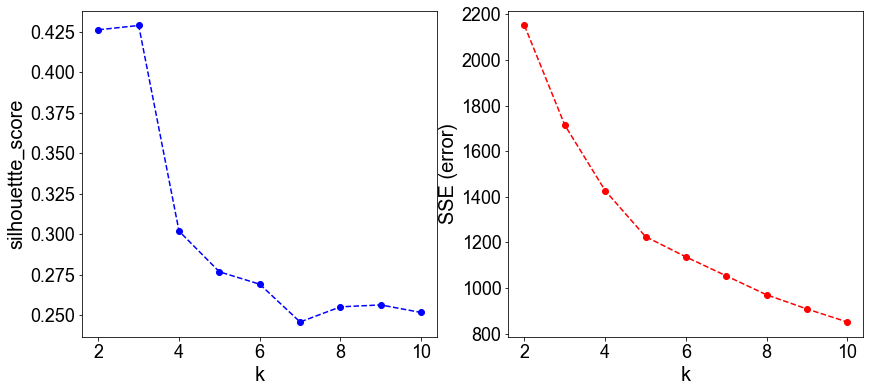

In [125]:
# k的选择
scores = []
SSE = []
for k in list(range(2, 11)):
    model = KMeans(n_clusters=k, random_state=100).fit(data1)
    scores.append(metrics.silhouette_score(data1, model.fit_predict(data1)))
    SSE.append(model.inertia_)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(list(range(2, 11)), scores, linestyle='--', marker='o', color='b')
plt.tick_params(labelsize=18)
plt.xlabel('k', size=20)
plt.ylabel('silhouettte_score', size=20);

plt.subplot(1,2,2)
plt.plot(list(range(2, 11)), SSE, linestyle='--', marker='o', color='r')
plt.tick_params(labelsize=18)
plt.xlabel('k', size=20)
plt.ylabel('SSE (error)', size=20);

- k=3

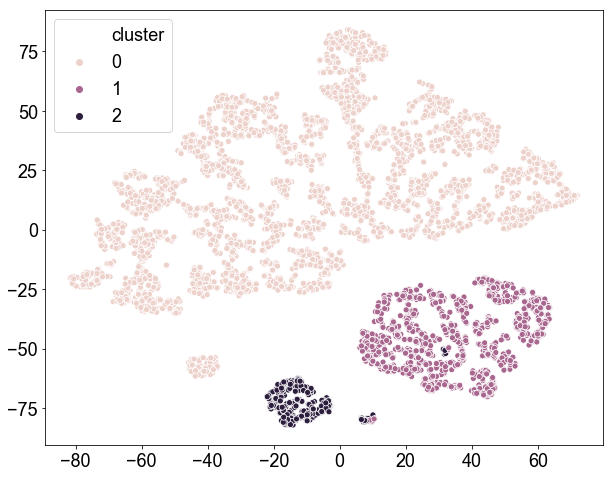

In [131]:
# 数据可视化
tsne = TSNE(n_components=2, init='random', random_state=100).fit(data1)
df=pd.DataFrame(tsne.embedding_)
df['cluster'] = model1.labels_

plt.figure(figsize=(10,8))
sns.scatterplot(x=df[0], y = df[1], hue = 'cluster', data=df)
plt.tick_params(labelsize=18)
plt.xlabel('', size=20)
plt.ylabel('', size=20)
plt.legend(fontsize=18, loc='best');

In [128]:
# 中心点
pd.DataFrame(model1.cluster_centers_, columns = data.columns.values)

,timeduration,tripduration,age,start_weekday,start_hour,usertype_Subscriber,gender_Male,gender_Unknown
0,0.331850,0.338141,0.441050,0.411318,0.571967,0.975781,1.000000e+00,-1.457168e-15
1,0.358751,0.363484,0.406522,0.407570,0.583742,0.993838,4.218847e-15,7.922535e-03
2,0.593457,0.589511,0.377599,0.569836,0.618034,0.024648,2.997602e-15,9.295775e-01


In [173]:
data['cluster'] = model1.labels_
data.groupby('cluster').mean()

,timeduration,tripduration,age,start_weekday,start_hour,usertype_Subscriber,gender_Male,gender_Unknown
cluster,,,,,,,,
0,8.964398,567.534754,36.524098,2.467910,13.155243,0.975781,1.0,0.000000
1,9.610035,605.499120,35.073944,2.445423,13.426056,0.993838,0.0,0.007923
2,15.242958,944.088028,33.859155,3.419014,14.214789,0.024648,0.0,0.929577


## 5.2 模型优化

In [135]:
# 2. 数据标准化
data2 = StandardScaler().fit_transform(data)

# 训练模型
model2 = KMeans(n_clusters=3, random_state=100).fit(data2)
# 评分
print("模型评分：%.4f" % metrics.silhouette_score(data2, model2.fit_predict(data2)))

模型评分：0.2555


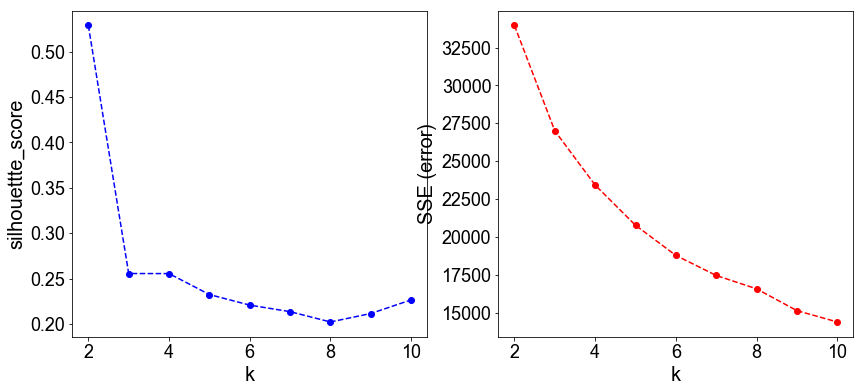

In [132]:
# 测试k
scores = []
SSE = []
for k in list(range(2, 11)):
    model = KMeans(n_clusters=k, random_state=100).fit(data2)
    scores.append(metrics.silhouette_score(data2, model.fit_predict(data2)))
    SSE.append(model.inertia_)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(list(range(2, 11)), scores, linestyle='--', marker='o', color='b')
plt.tick_params(labelsize=18)
plt.xlabel('k', size=20)
plt.ylabel('silhouettte_score', size=20);

plt.subplot(1,2,2)
plt.plot(list(range(2, 11)), SSE, linestyle='--', marker='o', color='r')
plt.tick_params(labelsize=18)
plt.xlabel('k', size=20)
plt.ylabel('SSE (error)', size=20);

- k=3

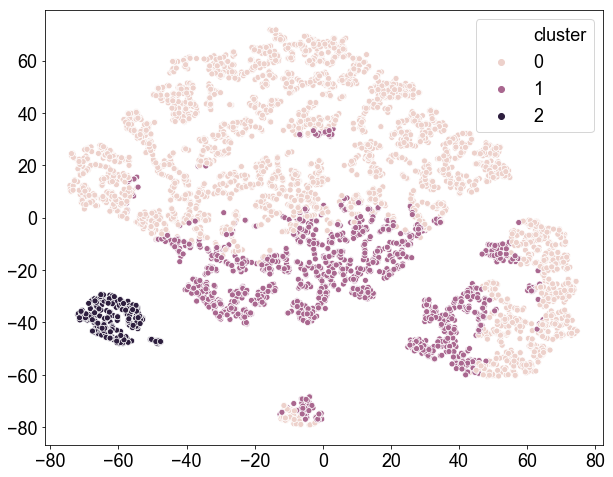

In [137]:
# 数据可视化
tsne = TSNE(n_components=2, init='random', random_state=100).fit(data2)
df=pd.DataFrame(tsne.embedding_)
df['cluster'] = model2.labels_

plt.figure(figsize=(10,8))
sns.scatterplot(x=df[0], y = df[1], hue = 'cluster', data=df)
plt.tick_params(labelsize=18)
plt.xlabel('', size=20)
plt.ylabel('', size=20)
plt.legend(fontsize=18, loc='best');

- 使用数据归一化

In [139]:
# 3. 分箱操作
data3 = mobike_clean.copy()

data3['weekday_or_weekend'] = pd.cut(data3['start_weekday'], bins = [0, 5, 7], right=False, labels = ['weekday', 'weekend'])
data3['hour_range'] = pd.cut(data3['start_hour'], bins = [0, 6, 12,18,24], right=False, labels=['0-6', '6-12', '12-18', '18-24'])
data3['age_range'] = pd.cut(data3['age'], bins=[0,25,50,70], right = False, labels = ['teen', 'youth', 'old'])

data3 = pd.concat([data3, pd.get_dummies(data3[['weekday_or_weekend', 'hour_range', 'age_range']], drop_first=True)], axis=1)

data3 = data3.drop(data3.select_dtypes(['object', 'category']), axis=1)

labels = data3.columns.values
data3 = MinMaxScaler().fit_transform(data3)

data3 =pd.DataFrame(data3, columns=labels)
data3.drop(['age', 'start_weekday', 'start_hour'], axis = 1, inplace = True)

# 训练模型
model3 = KMeans(n_clusters=4, random_state=100).fit(data3)
# 评分
print("模型评分：%.4f" % metrics.silhouette_score(data3, model3.fit_predict(data3)))

模型评分：0.4185


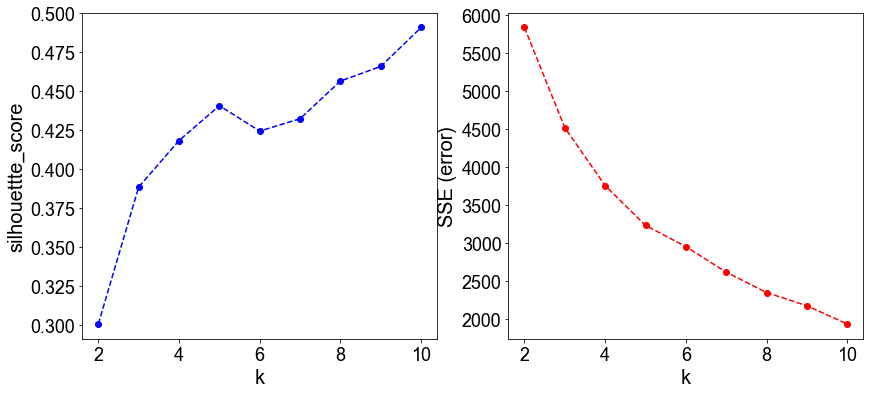

In [138]:
# 测试k
scores = []
SSE = []
for k in list(range(2, 11)):
    model = KMeans(n_clusters=k, random_state=100).fit(data3)
    scores.append(metrics.silhouette_score(data3, model.fit_predict(data3)))
    SSE.append(model.inertia_)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(list(range(2, 11)), scores, linestyle='--', marker='o', color='b')
plt.tick_params(labelsize=18)
plt.xlabel('k', size=20)
plt.ylabel('silhouettte_score', size=20);

plt.subplot(1,2,2)
plt.plot(list(range(2, 11)), SSE, linestyle='--', marker='o', color='r')
plt.tick_params(labelsize=18)
plt.xlabel('k', size=20)
plt.ylabel('SSE (error)', size=20);

- k=4?

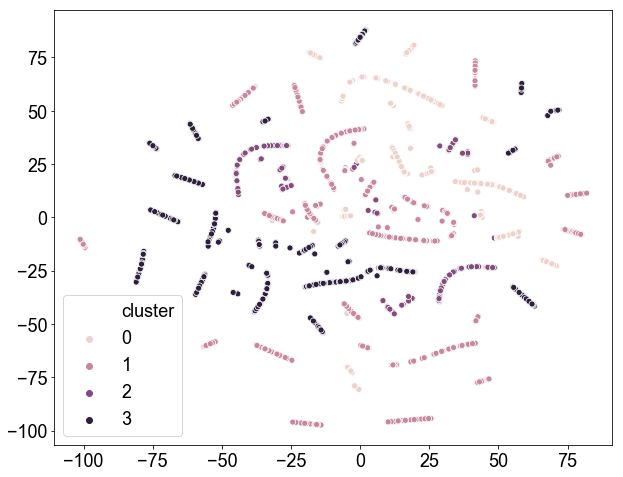

In [140]:
tsne = TSNE(n_components=2, init='random', random_state=100).fit(data3)
df=pd.DataFrame(tsne.embedding_)
df['cluster'] = model3.labels_

plt.figure(figsize=(10,8))
sns.scatterplot(x=df[0], y = df[1], hue = 'cluster', data=df)
plt.tick_params(labelsize=18)
plt.xlabel('', size=20)
plt.ylabel('', size=20)
plt.legend(fontsize=18, loc='best');

In [142]:
# 3. 换用DBSCAN模型+归一化数据
db = DBSCAN(eps=0.5, min_samples=20).fit(data1)

print("模型评分：%.4f" % metrics.silhouette_score(data1, db.fit_predict(data1)))

模型评分：0.4326


In [143]:
pd.Series(db.labels_).unique()

array([ 0,  3,  1,  2, -1])

In [172]:
tsne = TSNE(n_components=2, init='random', random_state=100).fit(data1)
df=pd.DataFrame(tsne.embedding_, columns=['0', '1'])
df['cluster'] = db.labels_

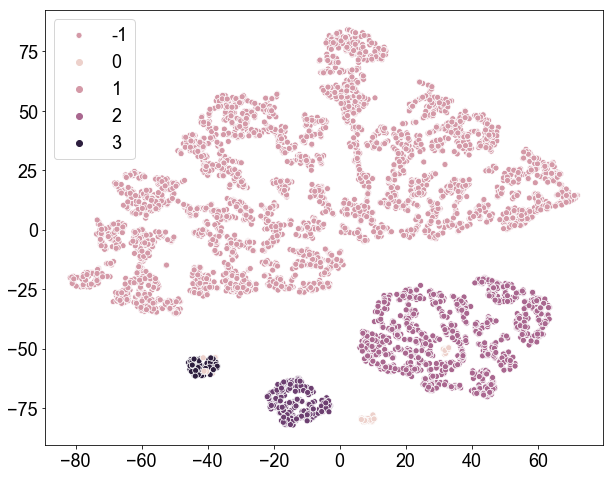

In [171]:
plt.figure(figsize=(10,8))

sns.scatterplot(x = '0', y='1', hue=db.fit_predict(data1), data=df)

plt.tick_params(labelsize=18)
plt.xlabel('', size=20)
plt.ylabel('', size=20)
plt.legend(['-1', '0', '1', '2', '3'], fontsize=18, loc='best')